**케라스를 사용한 인공 신경망**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 퍼셉트론

In [2]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris.target == 0).astype(int)
per_clf = Perceptron(n_jobs=-1)
per_clf.fit(X, y)
y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([0])

그림 저장: perceptron_iris_plot


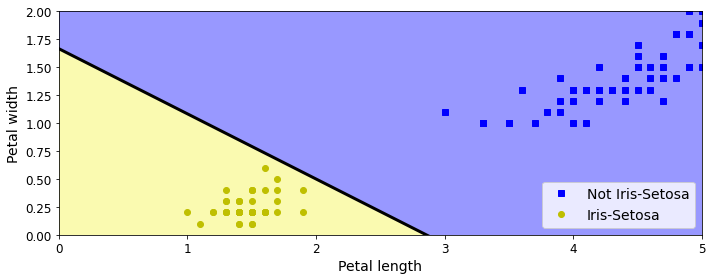

In [4]:
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1), np.linspace(axes[2], axes[3], 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris-Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
custom_cmap = ListedColormap(["#9898ff", "#fafab0"])
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
save_fig("perceptron_iris_plot")
plt.show()

# 활성화 함수

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def relu(z):
    return np.maximum(0, z)


def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

그림 저장: activation_functions_plot


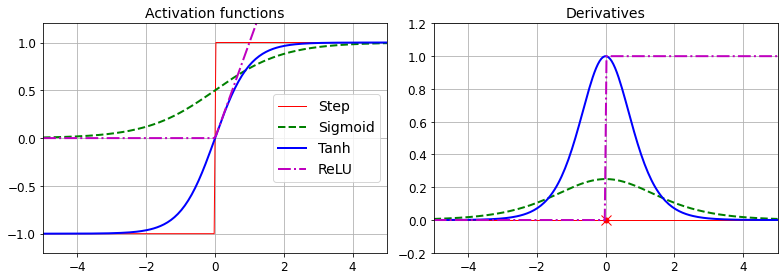

In [6]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])
plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
save_fig("activation_functions_plot")
plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)


def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

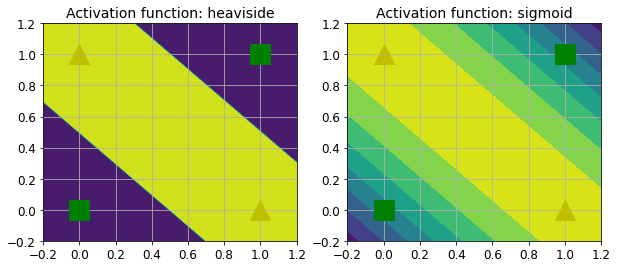

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)
z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)
plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# 이미지 분류기 만들기

먼저 텐서플로와 케라스를 임포트한다.

In [9]:
import tensorflow as tf

tf.__version__

'2.10.0'

In [10]:
from tensorflow import keras

keras.__version__

'2.10.0'

먼저 MNIST 데이터셋을 로드한다. 케라스는 `keras.datasets`에 널리 사용하는 데이터셋을 로드하기 위한 함수를 제공한다. 이 데이터셋은 이미 훈련 세트와 테스트 세트로 나누어져 있다. 훈련 세트를 더 나누어 검증 세트를 만드는 것이 좋다:

In [11]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

훈련 세트는 60,000개의 흑백 이미지이다. 각 이미지의 크기는 28x28 픽셀이다:

In [12]:
X_train_full.shape

(60000, 28, 28)

각 픽셀의 강도는 바이트(0~255)로 표현된다:

In [13]:
X_train_full.dtype

dtype('uint8')

전체 훈련 세트를 검증 세트와 (조금 더 작은) 훈련 세트로 나눈다. 또한 픽셀 강도를 255로 나누어 0~1 범위의 실수로 바꾼다.

In [14]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

맷플롯립의 `imshow()` 함수와 `'binary'` 컬러맵을 사용해 이미지를 출력한다:

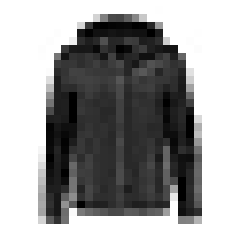

In [15]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

레이블은 0에서 9까지 (uint8로 표현된) 클래스 아이디이다:

In [16]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

클래스 이름은 다음과 같다:

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

훈련 세트에 있는 첫 번째 이미지는 코트이다:

In [18]:
class_names[y_train[0]]

'Coat'

검증 세트는 5,000개의 이미지를 담고 있고 테스트 세트는 10,000개의 이미지를 가진다:

In [19]:
X_valid.shape

(5000, 28, 28)

In [20]:
X_test.shape

(10000, 28, 28)

이 데이터셋에 있는 샘플 이미지를 몇 개 출력해 본다:

그림 저장: fashion_mnist_plot


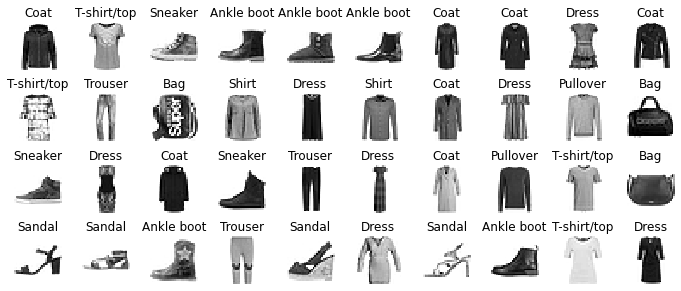

In [21]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig("fashion_mnist_plot", tight_layout=False)
plt.show()

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [23]:
keras.backend.clear_session()

In [24]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [25]:
model.layers

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


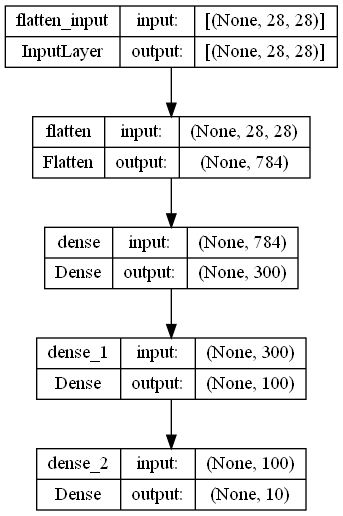

In [27]:
keras.utils.plot_model(model, os.path.join(IMAGES_PATH, "my_fashion_mnist_model.png"), show_shapes=True)